# Touch Detection Prototyping

## Goals and Requirements

### Input

The raw touch input is provided as capacitive heatmap.
The resolution of this heatmap is significantly lower than the resolution of the actual screen, which in turn may be lower than the final resolution in which the processed touch point descriptions should be provided.
The input is likely noisy, thus additional precautions may be necessary.

### Output

This project is mainly intended to provide a robust algorithm for use in a Linux kernel module.
In the Linux kernel, touch points can be described via an ellipse representing the contact point (see https://www.kernel.org/doc/html/latest/input/multi-touch-protocol.html for details).
Note: We will for now neglect the appropriate scaling of coordinates to output dimensions.
Thus the provided output for some touch point $i$ is $t_i = (c_i, \theta_i, h_i, w_i)$ with

- $c_i \in \mathbb{R}^{2}$ as the center of the contact point,
- $h_i \in \mathbb{R}$ as the height of the ellipse, i.e. its size along its major axis,
- $w_i \in \mathbb{R}$ as the width of the ellipse, i.e. its size along its minor axis (note that the axes are orthogonal), and
- $\theta_i \in [0,2\pi]$ as the angle of the major axis of the ellipse.

In addition, proper handling of touch points requires tracking of the contact points across consecutive input data frames.
This can be seen as a separate problem ontop of the contact point identification and will be discussed later.
Similarly, handling of noise can be discussed as a separate problem applied to the output data.

## First Approach: A Simplified Setting

Let us for now assume that we only have a single point of contact.
Considering that we need to model the contact point as an ellipse, a two-dimensional Gaussian $\mathcal{N}(x \mid \mu, \Sigma)$ seems like a good choice to start: The mean $\mu \in \mathbb{R}^2$ of the Gaussian directly provides us with the center of the contact point while a confidence bound derived from the covariance matrix $\Sigma \in \mathbb{R}^{2 \times 2}$ provides us with the shape of the ellipse.
This also allows for a neat probabilistic interpretation: $\mathcal{N}(x \mid \mu, \Sigma)$ represents the probability of $x \in \mathbb{R}^2$ being the center of the contact area.

Estimation of the Gaussian is fairly straightforward.
Note that we, however, do not deal with uniformly weighted random samples but instead with a grid, where points have associated values derived from the capacity data of the touchscreen, determining their sample weights.
This suggests modifying the classical maximum likelihood estimators (MLE), yielding

\begin{align*}
    \mathbb{E}[\mu] &= \sum_{(x_i, y_i) \in \mathcal{S}} y_i \cdot x_i \\
    \mathbb{E}[\Sigma] &= \sum_{(x_i, y_i) \in \mathcal{S}} y_i \cdot \left(x - \mu\right)
        \left(x - \mu\right)^\intercal
\end{align*}

where $S$ is the set of samples $x_i \in \mathbb{R}^2$ associated with normalized sample weights $y_i \in \mathbb{R}$, such that $\sum_i y_i = 1$ holds.

Let us now apply this.
First we generate some input data for a single contact point, using a Gaussian.
Here we already assume that the input data is pre-processed sufficiently and has normalized values.
We will neglect handling of noise and assume that there are no contact areas intersecting with the boundary.

In [1]:
# imports
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib notebook

In [2]:
# general parameters
input_width, input_height = 0x48, 0x30

In [3]:
def cov(angle, width, height):
    """Generate a 2D covariance matrix from the given confidence bound shape"""
    e1 = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]) @ np.array([1.0, 0.0])
    e2 = np.array([[0.0, -1.0], [1.0, 0.0]]) @ e1
    return height * np.outer(e1, e1) + width * np.outer(e2, e2)

def generate_input(width, height, params):
    data = np.zeros(shape=(width, height))

    for mu, sigma in params:
        for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
            data[x1, x2] += multivariate_normal.pdf(np.array([x1, x2]), mu, sigma)

    return data / np.sum(data)

# parameters for data
mu_real = np.array([15.3, 10.6])
sigma_real = cov(np.deg2rad(35), 1.0, 2.0)

# simulate input data
data = generate_input(input_width, input_height, [(mu_real, sigma_real)])

<IPython.core.display.Javascript object>


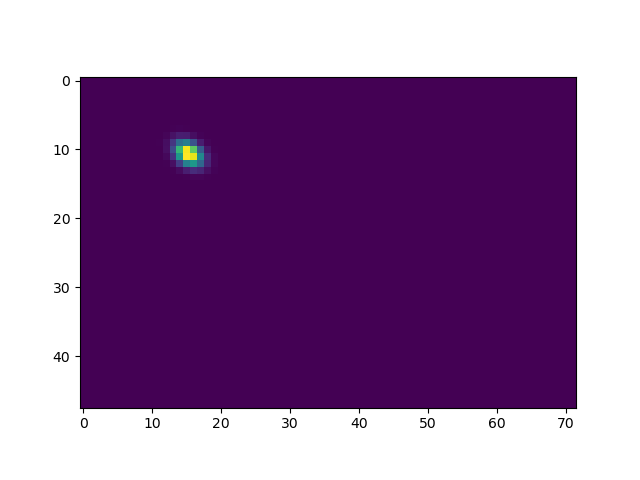

In [4]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
plt.show()

Now let's try to reconstruct the parameters for the original Gaussian using the MLEs.
First estimate the mean $\mu$:

In [5]:
def mle_mean(data):
    mu = np.zeros(shape=2)

    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        mu += np.array([x1, x2]) * data[x1, x2]

    return mu

mu = mle_mean(data)

and from that estimate the covariance matrix $\Sigma$:

In [6]:
def mle_cov(data, mu):
    sigma = np.zeros(shape=(2, 2))

    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        d = np.array([x1, x2]) - mu
        sigma += np.outer(d, d) * data[x1, x2]
    
    return sigma

sigma = mle_cov(data, mu)

To see how good this estimate is we can first look at the errors

In [7]:
print(f"error in mu:    {np.linalg.norm(mu_real - mu)}")
print(f"error in sigma: {np.linalg.norm(sigma_real - sigma, ord=np.inf)}")

error in mu:    4.2070441026438876e-11
error in sigma: 6.180222444918115e-10


and then also plot the results:

In [8]:
from matplotlib.patches import Ellipse

def plot_cov_ellipse(ax, mu, sigma, nstd, **kwargs):
    """Plot ellipse representing confidence bound with nstd times the standard deviation"""
    eigvals, eigvecs = np.linalg.eigh(sigma)

    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    angle = np.arctan2(vy, vx)

    width, height = 2.0 * nstd * np.sqrt(eigvals)
    ax.add_artist(Ellipse(xy=mu, width=width, height=height, angle=np.degrees(angle), **kwargs))

def plot_mean(ax, mu, **kwargs):
    """Plot mean as cross"""
    ax.plot([mu[0], mu[0]], [mu[1] - 0.5, mu[1] + 0.5], **kwargs)
    ax.plot([mu[0] - 0.5, mu[0] + 0.5], [mu[1], mu[1]], **kwargs)

def plot_gaussian(ax, mu, sigma, nstd, color):
    """Plot Gaussian with confidence bound"""
    plot_mean(ax, mu, color=color)
    plot_cov_ellipse(ax, mu, sigma, 2.0, facecolor='none', edgecolor=color)
    

<IPython.core.display.Javascript object>


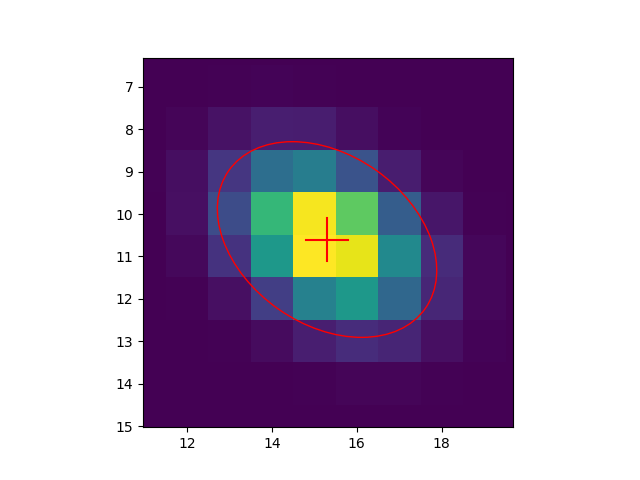

In [9]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu, sigma, 2.0, color='red')

As we can see, this provides a fairly good reconstruction.
Applied to real data, the estimator of the mean provides sufficiently good resolution and accuracy.
Tuning the `nstd` parameter allows to accurately reconstruct the physical contact area.
Performance, however, is suboptimal as we look at the full heatmap.
This can be improved by first identifying the maximum and then restricting mean and covariance computation to a local area around it.
Furthermore, these estimators break down completely when dealing with multiple touch points:

In [10]:
# generate two contact points
mu1 = np.array([10.0, 20.0])
mu2 = np.array([20.0, 20.0])
sigma = np.identity(2)
data = generate_input(input_width, input_height, [(mu1, sigma), (mu2, sigma)])

# estimate mean and covariance
mu = mle_mean(data)
sigma = mle_cov(data, mu)

<IPython.core.display.Javascript object>


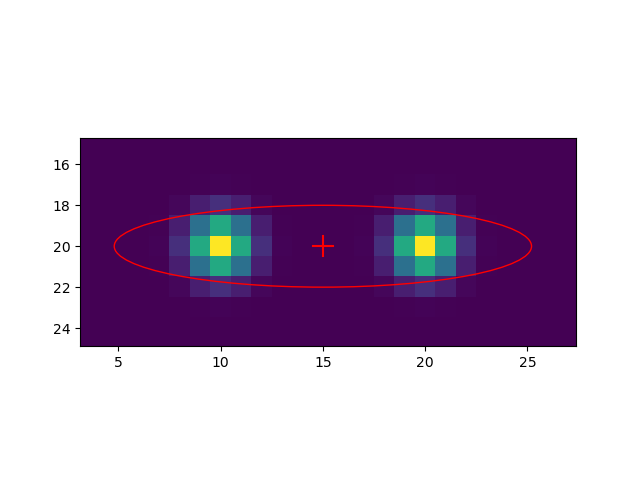

In [11]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu, sigma, 2.0, color='red')

This is expected, as our current estimators are only designed for reconstructing a single Gaussian.
Next, we will look at how we can extend this approach to multiple Gaussians.

## Extending the Approach to Multiple Contact Points

The basic idea of this is given in Gaussian Mixture Models (GMMs).
While GMMs generally work with random samples and we instead work on a grid with associated weights, the core idea is transferable.

In [12]:
# parameters for data
mu1_real = np.array([15.3, 10.6])
sigma1_real = cov(np.deg2rad(35), 1.0, 2.0)

mu2_real = np.array([35.8, 15.1])
sigma2_real = cov(np.deg2rad(-15), 1.0, 2.0)

# simulate input data
data = generate_input(input_width, input_height, [(mu1_real, sigma1_real), (mu2_real, sigma2_real)])

<IPython.core.display.Javascript object>


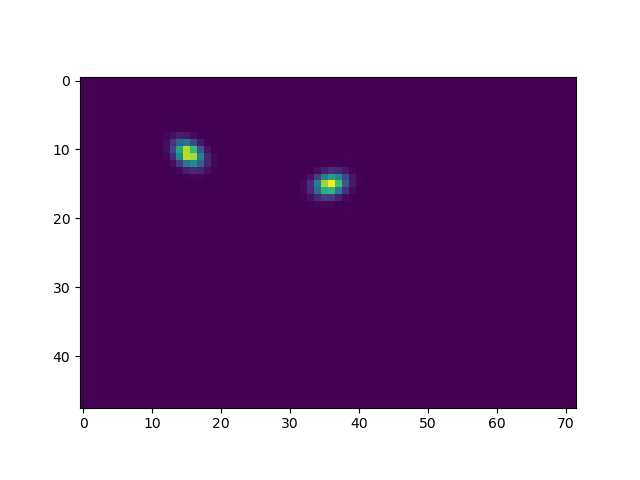

In [13]:
_fig, ax = plt.subplots()
ax.imshow(data.T)

In [14]:
def get_local_maximas(data, delta=0.01):
    threshold = np.average(data) + delta

    result = []
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        ax1, bx1 = max(x1 - 1, 0), min(x1 + 1, data.shape[0] - 1)
        ax2, bx2 = max(x2 - 1, 0), min(x2 + 1, data.shape[1] - 1)
        
        if data[x1, x2] < threshold:
            continue
        
        area = itertools.product(range(ax1, bx1+1), range(ax2, bx2+1))
        if np.all([(data[x1, x2] >= data[ix1, ix2]) for ix1, ix2 in area]):
            result += [np.array([x1, x2])]
            
    
    return result

maximas = get_local_maximas(data)
maximas

[array([15, 11]), array([36, 15])]

<IPython.core.display.Javascript object>


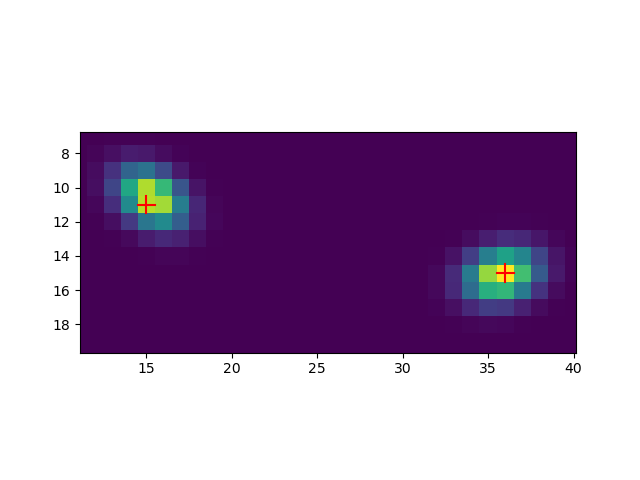

In [15]:
_fig, ax = plt.subplots()
ax.imshow(data.T)

for m in maximas:
    plot_mean(ax, m, color='red')

TODO: describe idea

In [16]:
# initial estimate
mu_init = maximas[0]
sigma_init = np.identity(2)

<IPython.core.display.Javascript object>


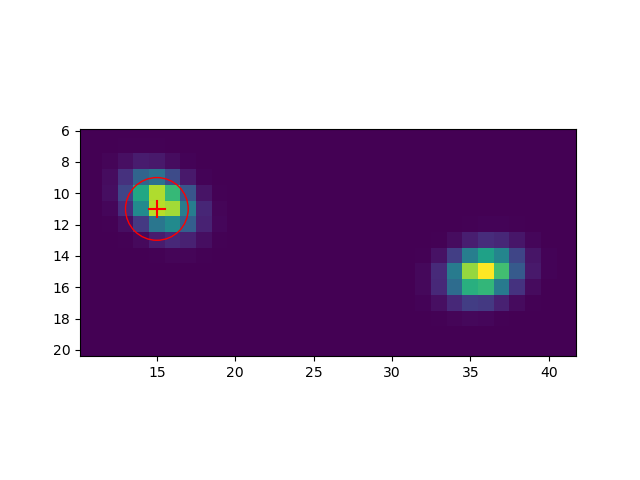

In [17]:
_fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu_init, sigma_init, 2.0, color='red')

In [18]:
def gmm_iteration(data, mu, sigma, nstd):
    mu_new = np.zeros(shape=2)
    sigma_new = np.zeros(shape=(2,2))
    
    # compute normalization factor
    norm = 0.0
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        if np.linalg.norm(np.linalg.inv(nstd * sigma) @ (np.array([x1, x2]) - mu)) <= 1.0:
            norm += data[x1, x2]

    # update estimate of mean
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        # only consider points local to _this_ gaussian
        if np.linalg.norm(np.linalg.inv(nstd * sigma) @ (np.array([x1, x2]) - mu)) > 1.0:
            continue

        # update estimate
        mu_new += np.array([x1, x2]) * (data[x1, x2] / norm)

    # update estimate of covariance
    for x1, x2 in itertools.product(range(0, data.shape[0]), range(0, data.shape[1])):
        # only consider points local to _this_ gaussian
        if np.linalg.norm(np.linalg.inv(nstd * sigma) @ (np.array([x1, x2]) - mu)) > 1.0:
            continue

        # update estimate
        d = np.array([x1, x2]) - mu
        sigma_new += np.outer(d, d) * (data[x1, x2] / norm)

    return mu_new, sigma_new

def gmm(data, mu_init, sigma_init, n_std, n_iter, mu_real, sigma_real):
    mu_est, sigma_est = mu_init, sigma_init

    for i in range(0, n_iter):
        mu_est, sigma_est = gmm_iteration(data, mu_est, sigma_est, n_std)

        print(f"iteration: {i}")
        print(f"  error in mu:    {np.linalg.norm(mu_real - mu_est)}")
        print(f"  error in sigma: {np.linalg.norm(sigma_real - sigma_est, ord=np.inf)}")
    
    return mu_est, sigma_est

iteration: 0
  error in mu:    0.04378948222285432
  error in sigma: 0.548997757707234
iteration: 1
  error in mu:    0.003213472880809921
  error in sigma: 0.05062013476157601
iteration: 2
  error in mu:    0.0012792131727829984
  error in sigma: 0.04680315968288701
iteration: 3
  error in mu:    0.005449702231153229
  error in sigma: 0.05547585192647264
iteration: 4
  error in mu:    0.005449702231153229
  error in sigma: 0.055494826593921964


<IPython.core.display.Javascript object>


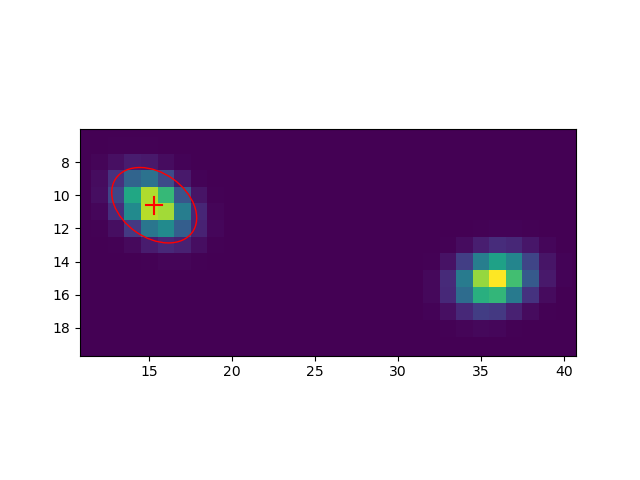

In [19]:
mu_est, sigma_est = gmm(data, mu_init, sigma_init, 3.0, 5, mu1_real, sigma1_real)

_fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu_est, sigma_est, 2.0, color='red')

iteration: 0
  error in mu:    0.04993767823178947
  error in sigma: 0.4948453813144976
iteration: 1
  error in mu:    0.0033848556054119293
  error in sigma: 0.07803833858545667
iteration: 2
  error in mu:    0.005568614325246142
  error in sigma: 0.07651834035730518
iteration: 3
  error in mu:    0.006333631985213717
  error in sigma: 0.07706638654332945
iteration: 4
  error in mu:    0.006333631985213717
  error in sigma: 0.07706631607970196


<IPython.core.display.Javascript object>


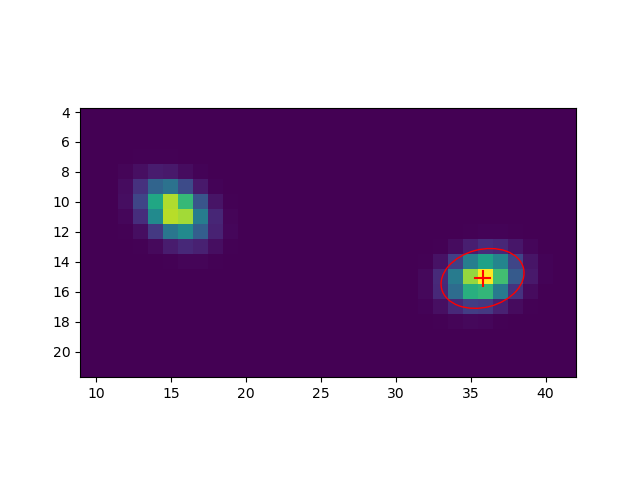

In [20]:
mu_est, sigma_est = gmm(data, maximas[1], np.identity(2), 3.0, 5, mu2_real, sigma2_real)

_fig, ax = plt.subplots()
ax.imshow(data.T)
plot_gaussian(ax, mu_est, sigma_est, 2.0, color='red')